In [32]:
# 1. Import Required Libraries
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from sklearn.calibration import calibration_curve
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [38]:
# 2. Configuration
# Define model configs for multiple HuggingFace control models and API (PromptForest)
CONTROL_MODELS = [
    {
        "name": "ProtectAI Deberta V3",
        "model_name": "protectai/deberta-v3-base-prompt-injection-v2",
        "device": "mps" if torch.backends.mps.is_available() else "cpu"
    },
    {
        "name": "Deepset",
        "model_name": "deepset/deberta-v3-base-injection",
        "device": "mps" if torch.backends.mps.is_available() else "cpu"
    },
    {
        "name": "Vijil Dome",
        "model_name": "vijil/vijil_dome_prompt_injection_detection",
        "device": "mps" if torch.backends.mps.is_available() else "cpu"
    },
    {
        "name": "Qualifire",
        "model_name": "qualifire/prompt-injection-sentinel",
        "device": "mps" if torch.backends.mps.is_available() else "cpu"
    },
    {
        "name": "Qualifire v2",
        "model_name": "qualifire/prompt-injection-jailbreak-sentinel-v2",
        "device": "mps" if torch.backends.mps.is_available() else "cpu"
    },

    {
        "name": "Llama PromptGuard 86M",
        "model_name": "meta-llama/Llama-Prompt-Guard-2-86M",
        "device": "mps" if torch.backends.mps.is_available() else "cpu"
    },


]
PF_SERVER_URL = "http://localhost:1000/analyze"
MAX_SAMPLES = 5000
BENCHMARK_DATASET = "qualifire/prompt-injections-benchmark"
BENCHMARK_SPLIT = "test"

In [39]:
# 3. Helper Functions
def parse_label(value):
    if isinstance(value, int): return value
    if isinstance(value, str):
        v = value.lower()
        if v in ["jailbreak", "malicious", "unsafe", "attack", "injection", "1"]: return 1
        if v in ["benign", "safe", "legit", "0"]: return 0
    try: return int(value)
    except: return 0

def get_control_prediction(text, tokenizer, model, device):
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()
        conf = probs[0][1].item()  # probability of class 1 (malicious)
        return pred, conf
    except Exception as e:
        print(f"Error inferencing: {e}")
        return 0, 0.5

def get_pf_prediction(text):
    try:
        resp = requests.post(PF_SERVER_URL, json={"prompt": text}, timeout=5)
        resp.raise_for_status()
        data = resp.json()
        pred_label = int(data.get("is_malicious", 0))
        conf = data.get("confidence")
        if conf is None:
            prob_malicious = 1.0 if pred_label == 1 else 0.0
        else:
            prob_malicious = conf if pred_label == 1 else 1 - conf
        return pred_label, prob_malicious
    except Exception as e:
        print(f"Request failed for text: {text[:30]}... -> {e}")
        return 0, 0.5

In [35]:
# 4. Load Benchmark Dataset
ds = load_dataset(BENCHMARK_DATASET, split=BENCHMARK_SPLIT)
ds = ds.shuffle(seed=42).select(range(min(len(ds), MAX_SAMPLES)))

In [40]:
# 5. Run Inference for Each Model
results = []

# Load and run inference for each control model
for control in CONTROL_MODELS:
    model_name = control['model_name']
    device = control['device']
    print(f"Loading control model: {model_name} on {device}...")
    if model_name.startswith("vijil"):
        # Use modernbert tokenizer
        tokenizer = AutoTokenizer.from_pretrained("answerdotai/modernBERT-base")
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, torch_dtype=torch.float16)
    model.to(device)
    model.eval()

    print(f"Running inference for {control['name']} (HuggingFace model)...")
    for ex in tqdm(ds, desc=control['name']):
        text = ex.get("text") or ex.get("prompt")
        if not text:
            continue
        label = parse_label(ex["label"])
        pred_label, prob_malicious = get_control_prediction(text, tokenizer, model, device)
        confidence = prob_malicious if pred_label == 1 else 1 - prob_malicious
        results.append({
            "model": control['name'],
            "label": label,
            "prediction": pred_label,
            "prob_malicious": prob_malicious,
            "confidence": confidence,
            "is_correct": pred_label == label
        })

# Run inference for PromptForest API
print("Running inference for PromptForest (API)...")
for ex in tqdm(ds, desc="PromptForest"):
    text = ex.get("text") or ex.get("prompt")
    if not text:
        continue
    label = parse_label(ex["label"])
    pred_label, prob_malicious = get_pf_prediction(text)
    confidence = prob_malicious if pred_label == 1 else 1 - prob_malicious
    results.append({
        "model": "PromptForest",
        "label": label,
        "prediction": pred_label,
        "prob_malicious": prob_malicious,
        "confidence": confidence,
        "is_correct": pred_label == label
    })

Loading control model: protectai/deberta-v3-base-prompt-injection-v2 on mps...
Running inference for ProtectAI Deberta V3 (HuggingFace model)...


ProtectAI Deberta V3: 100%|██████████| 5000/5000 [02:25<00:00, 34.43it/s]


Loading control model: deepset/deberta-v3-base-injection on mps...
Running inference for Deepset (HuggingFace model)...


Deepset: 100%|██████████| 5000/5000 [02:18<00:00, 36.01it/s]


Loading control model: vijil/vijil_dome_prompt_injection_detection on mps...
Running inference for Vijil Dome (HuggingFace model)...


Vijil Dome: 100%|██████████| 5000/5000 [01:56<00:00, 43.05it/s]


Loading control model: qualifire/prompt-injection-sentinel on mps...
Running inference for Qualifire (HuggingFace model)...


Qualifire: 100%|██████████| 5000/5000 [03:08<00:00, 26.46it/s]


Loading control model: qualifire/prompt-injection-jailbreak-sentinel-v2 on mps...
Running inference for Qualifire v2 (HuggingFace model)...


Qualifire v2: 100%|██████████| 5000/5000 [05:20<00:00, 15.58it/s]


Loading control model: meta-llama/Llama-Prompt-Guard-2-86M on mps...
Running inference for Llama PromptGuard 86M (HuggingFace model)...


Llama PromptGuard 86M: 100%|██████████| 5000/5000 [02:51<00:00, 29.19it/s]


Running inference for PromptForest (API)...


PromptForest: 100%|██████████| 5000/5000 [08:27<00:00,  9.84it/s]


In [41]:
# 6. Aggregate Results
df = pd.DataFrame(results)
df.head()

,model,label,prediction,prob_malicious,confidence,is_correct
0,ProtectAI Deberta V3,1,0,1.978874e-04,0.999802,False
1,ProtectAI Deberta V3,1,1,9.941406e-01,0.994141,True
2,ProtectAI Deberta V3,0,0,8.940697e-07,0.999999,True
3,ProtectAI Deberta V3,0,0,8.344650e-07,0.999999,True
4,ProtectAI Deberta V3,0,1,1.000000e+00,1.000000,False


In [48]:
# 7. Compute Metrics (Accuracy, ECE, etc.)
from collections import defaultdict
metrics = defaultdict(dict)

for model in df['model'].unique():
    sub = df[df['model'] == model]
    accuracy = sub['is_correct'].mean()
    wrong_df = sub[~sub['is_correct']]
    right_df = sub[sub['is_correct']]
    avg_conf_wrong = wrong_df['confidence'].mean() if not wrong_df.empty else 0
    avg_conf_right = right_df['confidence'].mean() if not right_df.empty else 0
    probs = np.array(sub['prob_malicious'])
    labels = np.array(sub['label'])
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10)
    ece = np.mean(np.abs(prob_true - prob_pred))
    metrics[model]['accuracy'] = accuracy
    metrics[model]['avg_conf_wrong'] = avg_conf_wrong
    metrics[model]['ece'] = ece
    metrics[model]['prob_true'] = prob_true
    metrics[model]['prob_pred'] = prob_pred
    metrics[model]['avg_conf_right'] = avg_conf_right

In [49]:
# 8. Compare Model Results
summary = []
for model in df['model'].unique():
    summary.append({
        'Model': model,
        'Accuracy': metrics[model]['accuracy'],
        'Avg Conf (Wrong)': metrics[model]['avg_conf_wrong'],
        'Avg Conf (Right)': metrics[model]['avg_conf_right'],
        'ECE': metrics[model]['ece'],
    })
pd.DataFrame(summary).set_index('Model')

,Accuracy,Avg Conf (Wrong),Avg Conf (Right),ECE
Model,,,,
ProtectAI Deberta V3,0.7218,0.974424,0.989165,0.193891
Deepset,0.5852,0.992263,0.994458,0.416605
Vijil Dome,0.9070,0.921080,0.990234,0.213704
Qualifire,0.9808,0.916226,0.998434,0.186782
Qualifire v2,0.9724,0.782644,0.984385,0.059842
Llama PromptGuard 86M,0.7658,0.899437,0.968126,0.182661
PromptForest,0.8310,0.649977,0.859176,0.048777


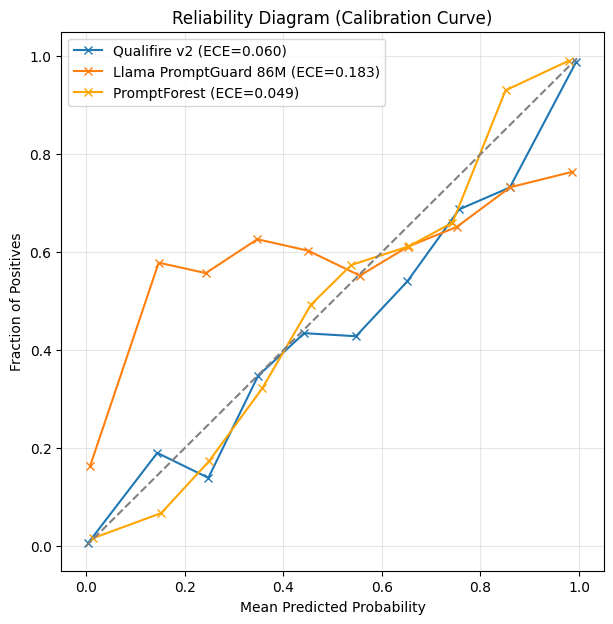

In [51]:
# 9. Plot Reliability Diagrams for All Models
plt.figure(figsize=(7, 7))
colors = {"Control": "blue", "PromptForest": "orange"}
for model in df['model'].unique():
    if model not in ['PromptForest', 'Qualifire v2', 'Llama PromptGuard 86M']:
        continue
    color = colors.get(model, None)
    plt.plot(metrics[model]['prob_pred'], metrics[model]['prob_true'], marker='x', label=f"{model} (ECE={metrics[model]['ece']:.3f})", color=color)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram (Calibration Curve)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()